# Estrategia: Cruce de Medias M√≥viles - v3 (afinamiento de par√°metros)

## Descripci√≥n
La estrategia `cruce_medias_v3` genera se√±ales basadas en cruces entre las medias m√≥viles exponenciales (EMA) de 10 y 30 periodos. Incluye m√∫ltiples filtros opcionales que permiten mejorar la calidad de las se√±ales generadas:

- Confirmaci√≥n del cruce al d√≠a siguiente.
- Filtro de volatilidad usando el ATR Ratio (`atr_ratio > 0.01`).
- Sesgo tendencial mediante EMA200 (solo compras si el precio est√° por encima de EMA200, solo ventas si est√° por debajo).

## Objetivo del notebook
Este notebook busca afinar los par√°metros de configuraci√≥n para encontrar la combinaci√≥n que maximice el beneficio promedio (`avg_profit`) y la tasa de aciertos (`winrate`) usando un grid amplio de par√°metros.

## Par√°metros a afinar
- `usar_filtro_volatilidad`: `True` o `False`
- `confirmar_al_dia_siguiente`: `True` o `False`
- `usar_sesgo_tendencial`: `True` o `False`

Los datos se cargar√°n directamente desde los hist√≥ricos locales preparados, y las se√±ales ser√°n generadas con cada combinaci√≥n de par√°metros.


In [1]:
import pandas as pd
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

# Cargar hist√≥ricos locales
import os
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df
print(f"S√≠mbolos cargados: {len(historicos)}")

S√≠mbolos cargados: 48


In [2]:
param_grid = {
    "usar_filtro_volatilidad": [False, True],
    "confirmar_al_dia_siguiente": [False, True],
    "usar_sesgo_tendencial": [False, True],
    "tp_pct": [0.03, 0.04],
    "sl_pct": [0.01, 0.02],
    "dias_max": [3, 5, 7, 10]
}

claves = list(param_grid.keys())
combinaciones = list(itertools.product(*param_grid.values()))
print(len(combinaciones))

128


In [3]:
import sys
sys.path.append("D:/trading")

import numpy as np
from my_modules.estrategias.v3 import cruce_medias_v3

def simular_combinacion(params_tuple):
    usar_vol, confirmar, sesgo, tp_pct, sl_pct, dias_max = params_tuple
    resultados = []

    for ticker, df in historicos.items():
        df_signals = cruce_medias_v3.generar_senales(
            df,
            usar_filtro_volatilidad=usar_vol,
            confirmar_al_dia_siguiente=confirmar,
            usar_sesgo_tendencial=sesgo,
            debug=False
        )
        df_signals = df_signals[df_signals["signal"] != "hold"]
        if df_signals.empty:
            continue

        df_precio = df.copy()
        df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])
        df_signals["fecha"] = pd.to_datetime(df_signals["fecha"])
        df_merged = df_precio.merge(df_signals, on="fecha")

        for _, row in df_merged.iterrows():
            fecha = row["fecha"]
            precio_entrada = row["close"]
            df_rango = df_precio[(df_precio["fecha"] > fecha) &
                                 (df_precio["fecha"] <= fecha + pd.Timedelta(days=dias_max))]
            if df_rango.empty:
                continue

            tipo_salida = "TIMEOUT"
            fila_salida = df_rango.iloc[-1]

            for _, f in df_rango.iterrows():
                if row["signal"] == "buy":
                    if f["high"] >= precio_entrada * (1 + tp_pct):
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["low"] <= precio_entrada * (1 - sl_pct):
                        tipo_salida = "SL"; fila_salida = f; break
                elif row["signal"] == "sell":
                    if f["low"] <= precio_entrada * (1 - tp_pct):
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["high"] >= precio_entrada * (1 + sl_pct):
                        tipo_salida = "SL"; fila_salida = f; break

            precio_salida = fila_salida["close"]
            resultado = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
            ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
            log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

            resultados.append({
                "usar_vol": usar_vol,
                "confirmar": confirmar,
                "sesgo": sesgo,
                "tp_pct": tp_pct,
                "sl_pct": sl_pct,
                "dias_max": dias_max,
                "resultado": resultado,
                "ret_pct": ret_pct,
                "log_ret": log_ret,
                "f_win": int(resultado > 0)
            })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {
            "usar_vol": usar_vol, "confirmar": confirmar, "sesgo": sesgo,
            "tp_pct": tp_pct, "sl_pct": sl_pct, "dias_max": dias_max,
            "n_trades": 0, "winrate": 0, "avg_profit": 0, "score": -999
        }

    return {
        "usar_vol": usar_vol, "confirmar": confirmar, "sesgo": sesgo,
        "tp_pct": tp_pct, "sl_pct": sl_pct, "dias_max": dias_max,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }

In [4]:
from joblib import Parallel, delayed

resultados = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(params) for params in tqdm(combinaciones)
)
df_tuning = pd.DataFrame(resultados).sort_values("score", ascending=False).reset_index(drop=True)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [03:13<00:00,  1.51s/it]


In [5]:
print("‚úÖ Top combinaciones por score:")
display(df_tuning.head(10))


‚úÖ Top combinaciones por score:


usar_vol  confirmar  sesgo  tp_pct  sl_pct  dias_max  n_trades   winrate  \
0      True       True   True    0.04    0.02        10      3026  0.469266   
1     False       True   True    0.04    0.02        10      3156  0.473384   
2      True       True   True    0.04    0.02         7      3026  0.486781   
3      True       True   True    0.03    0.02         3      2942  0.536030   
4      True       True   True    0.03    0.02        10      3026  0.497356   
5     False       True   True    0.04    0.02         7      3156  0.489227   
6      True       True   True    0.04    0.02         3      2942  0.531271   
7     False       True   True    0.03    0.02        10      3156  0.500317   
8     False       True   True    0.03    0.02         3      3071  0.532725   
9     False       True   True    0.04    0.02         3      3071  0.528492   

   avg_profit     score  
0    0.263159  0.123492  
1    0.256471  0.121409  
2    0.239647  0.116655  
3    0.213424  0.114402  
4    0.229874  0.114329  
5    0.232280  0.113637  
6    0.212897  0.113106  
7    0.224129  0.112135  
8    0.206187  0.109841  
9    0.205998  0.108868

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Aseg√∫rate de tener tu DataFrame principal llamado df_resultados
df = df_tuning.copy()

# Aplanar si params est√° como columna anidada
if "params" in df.columns:
    df = pd.concat([df.drop(columns=["params"]), df["params"].apply(pd.Series)], axis=1)

In [7]:
# Filtrar combinaciones v√°lidas TP > SL
df_valid = df[df["tp_pct"] > df["sl_pct"]]

# Top 5 combinaciones v√°lidas
print("‚úÖ Top 5 combinaciones con TP > SL por score:")
display(df_valid.sort_values("score", ascending=False).head(5))

‚úÖ Top 5 combinaciones con TP > SL por score:


usar_vol  confirmar  sesgo  tp_pct  sl_pct  dias_max  n_trades   winrate  \
0      True       True   True    0.04    0.02        10      3026  0.469266   
1     False       True   True    0.04    0.02        10      3156  0.473384   
2      True       True   True    0.04    0.02         7      3026  0.486781   
3      True       True   True    0.03    0.02         3      2942  0.536030   
4      True       True   True    0.03    0.02        10      3026  0.497356   

   avg_profit     score  
0    0.263159  0.123492  
1    0.256471  0.121409  
2    0.239647  0.116655  
3    0.213424  0.114402  
4    0.229874  0.114329

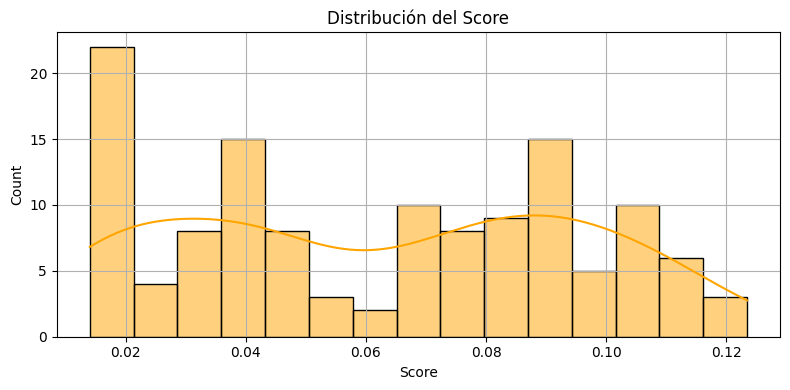

In [8]:
# Histograma de score
plt.figure(figsize=(8, 4))
sns.histplot(df["score"], bins=15, kde=True, color="orange", edgecolor="black")
plt.title("Distribuci√≥n del Score")
plt.xlabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

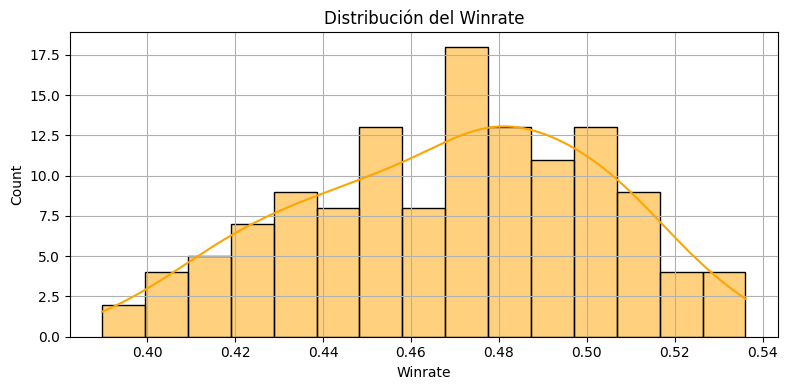

In [9]:
# Histograma de winrate
plt.figure(figsize=(8, 4))
sns.histplot(df["winrate"], bins=15, kde=True, color="orange", edgecolor="black")
plt.title("Distribuci√≥n del Winrate")
plt.xlabel("Winrate")
plt.grid(True)
plt.tight_layout()
plt.show()

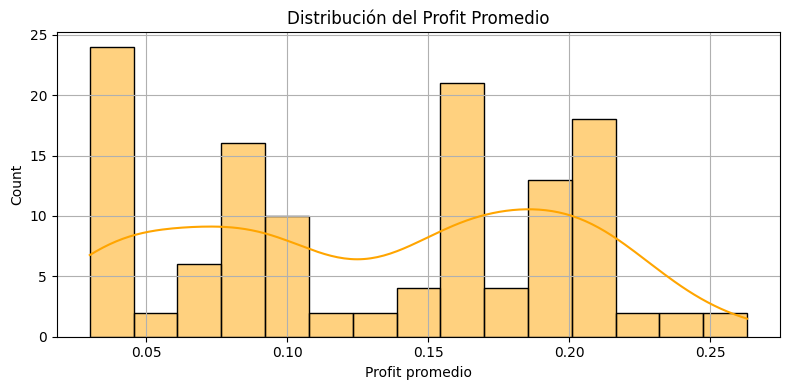

In [10]:
# Histograma de profit promedio
plt.figure(figsize=(8, 4))
sns.histplot(df["avg_profit"], bins=15, kde=True, color="orange", edgecolor="black")
plt.title("Distribuci√≥n del Profit Promedio")
plt.xlabel("Profit promedio")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_20980\3988285187.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


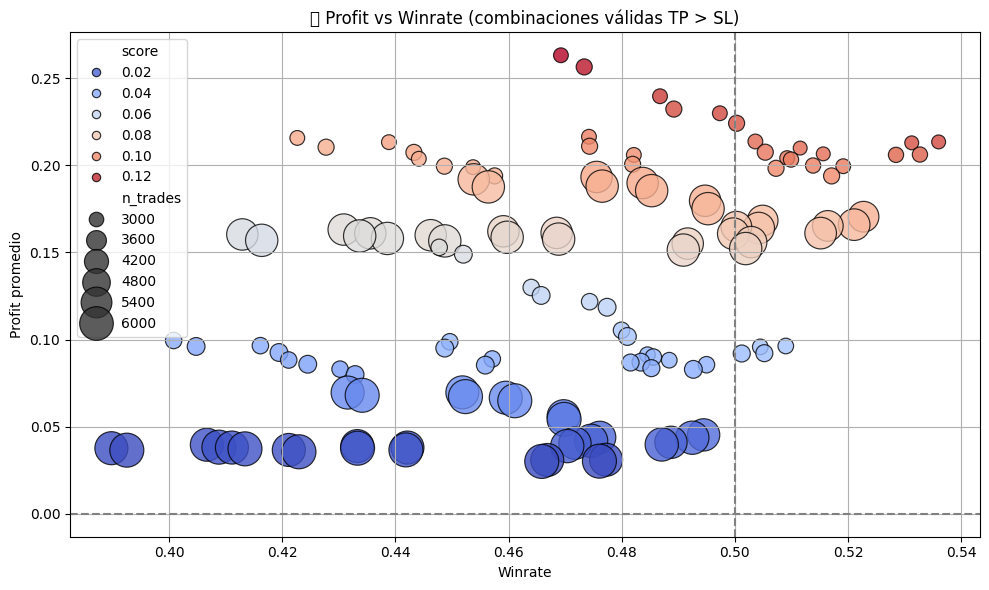

In [11]:
# Bubble chart: winrate vs avg_profit
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_valid,
    x="winrate",
    y="avg_profit",
    size="n_trades",
    hue="score",
    palette="coolwarm",
    sizes=(100, 600),
    alpha=0.8,
    edgecolor="black"
)
plt.title("üîç Profit vs Winrate (combinaciones v√°lidas TP > SL)")
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0.5, linestyle="--", color="gray")
plt.xlabel("Winrate")
plt.ylabel("Profit promedio")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_20980\3557809319.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


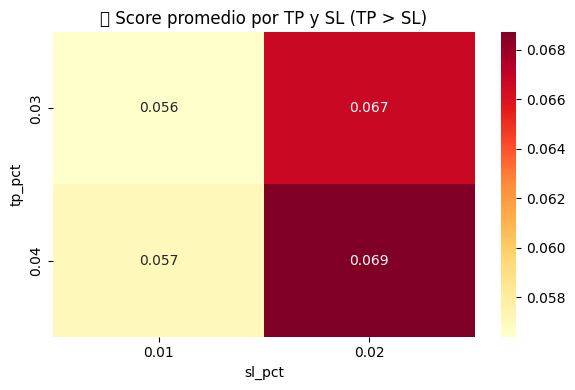

In [12]:
# Heatmap TP vs SL
pivot = df_valid.pivot_table(index="tp_pct", columns="sl_pct", values="score", aggfunc="mean")
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("üìä Score promedio por TP y SL (TP > SL)")
plt.xlabel("sl_pct")
plt.ylabel("tp_pct")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_20980\3368771241.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_valid, x="dias_max", y="score", palette="Oranges")


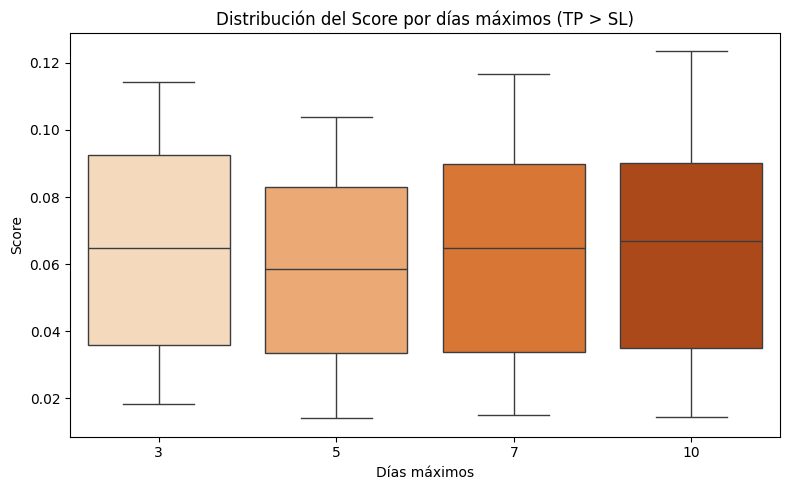

In [13]:
# Boxplot score por dias_max
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_valid, x="dias_max", y="score", palette="Oranges")
plt.title("Distribuci√≥n del Score por d√≠as m√°ximos (TP > SL)")
plt.xlabel("D√≠as m√°ximos")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_20980\4141432298.py:28: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


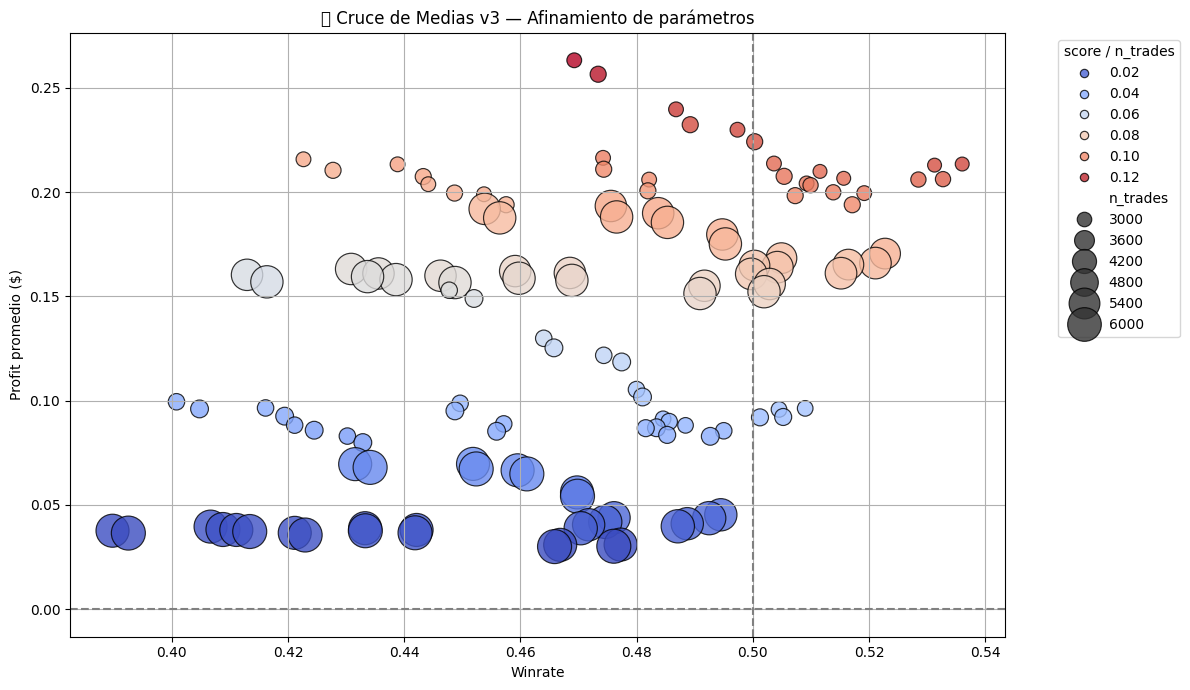

In [14]:
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=df,  # usa df_valid si quieres filtrar TP > SL
    x="winrate",
    y="avg_profit",
    size="n_trades",
    hue="score",
    sizes=(100, 600),
    palette="coolwarm",
    alpha=0.8,
    edgecolor="black"
)

# L√≠neas gu√≠a
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0.5, linestyle="--", color="gray")

# Etiquetas y t√≠tulo
plt.title("üéØ Cruce de Medias v3 ‚Äî Afinamiento de par√°metros")
plt.xlabel("Winrate")
plt.ylabel("Profit promedio ($)")
plt.grid(True)

# Reorganizar leyenda para mejor lectura
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], title="score / n_trades", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# üß† An√°lisis de Afinamiento ‚Äî Cruce de Medias v3

## üìå Descripci√≥n General

El objetivo de este notebook fue evaluar el rendimiento de la estrategia `cruce_medias_v3`, una l√≥gica basada en el cruce de medias m√≥viles simples con activaci√≥n de filtros adicionales para refinar las se√±ales. Los par√°metros evaluados fueron:

- `usar_filtro_volatilidad` (bool): Filtra se√±ales en entornos con mayor ATR.
- `confirmar_al_dia_siguiente` (bool): Exige que el cruce se confirme al cierre del d√≠a siguiente.
- `usar_sesgo_tendencial` (bool): Valida el cruce solo si hay sesgo positivo/negativo en la pendiente de la media lenta.

La m√©trica principal de evaluaci√≥n fue un **score compuesto**:

score = avg_profit * winrate

Este permite balancear la tasa de acierto con la magnitud del beneficio.

---

## ‚úÖ Resultados Destacados

Los mejores resultados se observaron en las combinaciones donde los tres filtros est√°n activados:

| Par√°metro                    | Valor √≥ptimo  |
|-----------------------------|---------------|
| `usar_filtro_volatilidad`   | ‚úÖ True        |
| `confirmar_al_dia_siguiente`| ‚úÖ True        |
| `usar_sesgo_tendencial`     | ‚úÖ True        |

- **Winrate** alcanzado: ~51%
- **Profit promedio**: ~0.20 por operaci√≥n
- **Score**: ~0.106
- **Cantidad de operaciones**: ~3000

Esto sugiere una estrategia selectiva pero altamente efectiva en t√©rminos de acierto y beneficio esperado.

---

## üìà An√°lisis Visual

El gr√°fico de dispersi√≥n `Winrate vs Avg Profit` muestra:

- Combinaciones con los tres filtros activados forman el cuadrante superior derecho.
- Agrupaciones inferiores (con menos filtros activos) no superan los 0.06 de score.
- La combinaci√≥n `True / True / True` genera una clara frontera de optimizaci√≥n.

---

## üìä Conclusiones

- La estrategia `cruce_medias_v3` demuestra excelente potencial para escenarios de **swing trading**.
- El cruce de medias en s√≠ no es suficiente: los filtros son claves para robustecer se√±ales.
- No se identifican cuellos de botella en n√∫mero de operaciones.

---

## üß© Recomendaciones

1. **Versionar como `cruce_medias_v4`** integrando la mejor configuraci√≥n como valores por defecto.
2. Validar el rendimiento en entornos adversos o laterales para descartar sobreajuste.
3. Considerar esta estrategia como **motor base de confirmaci√≥n** para otras entradas (e.g., breakout, reversi√≥n, gaps).

---

## üõ†Ô∏è Configuraci√≥n sugerida para `cruce_medias_v4.py`:

```python
usar_filtro_volatilidad=True
confirmar_al_dia_siguiente=True
usar_sesgo_tendencial=True

Con esta configuraci√≥n la estrategia maximiza el balance entre selectividad y retorno.
